![](../images/Title_ex_6.2.4.png)

# 1. Introduction

In this notebook we will explore some other drought indices and platforms on where to retrieve relevant information. First we will have a look at the Standardized Precipitation-Evapotranspiration Index (SPEI). This index is based on a standardized anomaly of precipitation and evapotranspiration varying with different timescales (averaged over 1 month: spei01, averaged over 3 months: spei03 and so on). The data at a resolution of 1°x1° can be viewed and downloaded [here](https://spei.csic.es/map/maps.html#months=1#month=5#year=2022) this dataset is available up till now. The higher resolution dataset of 0.5°x0.5° runs until december 2020 and can be viewed and downloaded [here](https://spei.csic.es/spei_database/#map_name=spei03#map_position=1439).

Both datasets have been downloaded for you and are available in the /data folder of this exercise.


Something about LST and ERA5 data? 

# 2. Libraries

In [9]:
import requests
import pandas as pd
import os
import matplotlib.pyplot as plt
# import netCDF4 as nc
import rioxarray
import cftime
import xarray

To run this notebook you need to install the **cftime** and **nc-time-axis** python packages.

# 3. SPEI

The datasets can be downloaded as a NetCDF file (.nc). We can open such files with different packages like NetCDF4, rioxarray, gdal... In this notebook we will show how to retrieve the data and plot timeseries using the rioxarray package. 

## 3.1 Reading NetCDF files

In [17]:
# Reading the one degree dataset...
fn = './data/spei03_one_degree.nc' 
spei_ds = rioxarray.open_rasterio(fn)
# # to shorten the list and delete recurring units
spei_ds.attrs['units'] = 'Standardized values' 
spei_ds

<xarray.DataArray 'spei' (time: 871, y: 180, x: 360)>
[56440800 values with dtype=float32]
Coordinates:
  * time         (time) object 1950-01-01 00:00:00 ... 2022-07-01 00:00:00
  * x            (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * y            (y) float64 0.5 1.5 2.5 3.5 4.5 ... 176.5 177.5 178.5 179.5
    spatial_ref  int64 0
Attributes:
    long_name:     standardized precipitation-evapotranspiration index
    units:         Standardized values
    _FillValue:    -1.0000000200408773e+20
    scale_factor:  1.0
    add_offset:    0.0

As you can see in the coordinates of this layer stack, the time represents each month from the first of January 1950 up until the first of July 2022. The x coordinate represents the longitude of the center of the pixel, whereas the y coordinate represents the central latitude of the pixel. Keep in mind that the coordinate spei_ds[0, 0, 0] represents the SPEI value from the pixel with central WGS84 cooordinates 179.5 E and 89.5 N at the Januari first 1950. Therefore, we should be careful when selecting the right coordinates.

In [18]:
# read the 0.5 degree resolution dataset...
fn = './data/spei03_half_degree.nc' 
spei_ds2 = rioxarray.open_rasterio(fn)
spei_ds2.attrs['units'] = 'z-values' 
spei_ds2

<xarray.DataArray 'spei' (time: 1440, y: 360, x: 720)>
[373248000 values with dtype=float32]
Coordinates:
  * time         (time) object 1901-01-16 00:00:00 ... 2020-12-16 00:00:00
  * x            (x) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * y            (y) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
    spatial_ref  int64 0
Attributes:
    long_name:     Standardized Precipitation-Evapotranspiration Index
    units:         z-values
    _FillValue:    1.0000000150474662e+30
    scale_factor:  1.0
    add_offset:    0.0

Note that the spatial coordinates in this dataset are defined differently compared to the 1° version!

## 3.2 Plot SPEI area for a specific date

The date in this NetCDF files is stored as a cftime.DatetimeProlepticGregorian type. In order to call the right month we need to take this into account. 

Let's say you want to retrieve the SPEI map for August in 2015 for the continent of Africa. You can enter the following query.

Note: to get a latitude from 40 N to 38 S we need to subtract and add these values from 90 because the equator has pixelnumber 90. Same logic applies to the longitude.

In [19]:
array = spei_ds[spei_ds.time == cftime.DatetimeProlepticGregorian(2015, 8, 1), # coordinate 1: timeperiod in proleptic gregorian
                (90-40):(90+38), # latitude accounting for the pixel numbering in the array 
                (180-25):(180+55)] # longitude accounting for the pixel numbering in the array 

In order to get nice maps, we need to mask out the pixels with the "FillValue"

In [20]:
array_mask = array.where(array != array._FillValue)

Now we can plot the SPEI map:

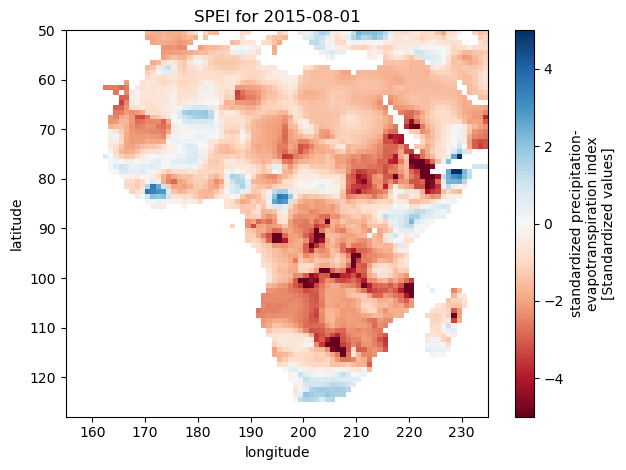

In [21]:
array_mask.plot(cmap="RdBu")
plt.title("SPEI for 2015-08-01")
plt.ylabel("latitude")
plt.xlabel("longitude")
# we need to invert the latitude axis in order to correctly visualize the result
plt.gca().invert_yaxis()
plt.tight_layout()
plt.draw()

## 3.3 Plot timeseries for a specific point

When interested in the SPEI values of a specific pixel over a long period of time, the query can be altered:

In [22]:
array_pt = spei_ds[(spei_ds.time >= cftime.DatetimeProlepticGregorian(2010, 1, 1)) & 
                 (spei_ds.time <= cftime.DatetimeProlepticGregorian(2020, 12, 1)),  # coordinate 1: timeperiod in proleptic gregorian
                 (90+4), # latitude accounting for the pixel numbering in the array 
                 (180+23)] # longitude accounting for the pixel numbering in the array 

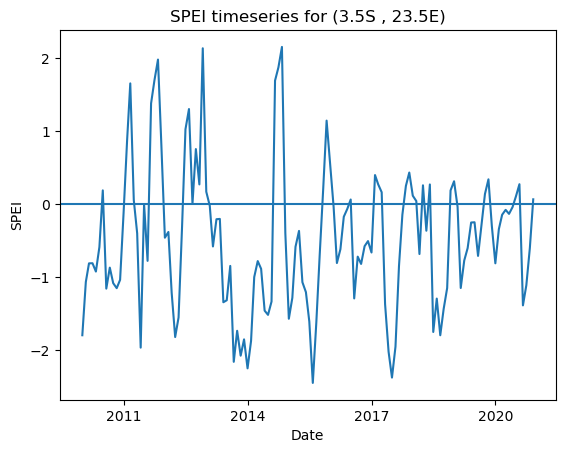

In [23]:
array_pt.plot()
plt.title("SPEI timeseries for (3.5S , 23.5E)")
plt.xlabel('Date')
plt.ylabel('SPEI')
plt.axhline(y=0)

Inspect the plot above and reflect on the meaning of the SPEI indicator. What does a positive and negative value imply?

# 4. Land surface temperature - air temperature

In exercise 6.2.2 we downloaded some land surface temperature data from the MODIS sensor. When combining this information with ambient air temperature, we end up with a generic indicator on drought stress...